In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
!pip install factor_analyzer
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 597 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 199 kB 17.8 MB/s 
     |████████████████████████████████| 8.8 MB 28.8 MB/s 
     |████████████████████████████████| 98 kB 9.2 MB/s 
     |████████████████████████████████| 468 kB 75.8 MB/s 
  Created wheel for factor-analyzer: filename=factor_analyzer-0.4.1-py2.py3-none-any.whl size=42034 sha256=f23537d29b447a7f4573d71e1858ec14110a6a630c0750e65cebec5a447d2aec
  Stored in directory: /root/.cache/pip/wheels/ed/90/48/766e09628cc5bbcf57c2eb063972c1e956a03422dd6d84fde2
Successfully built factor-analyzer


In [ ]:
def generate_col_to_drop(category, drop_cat_QP=True):
  cat = 'ABCDE'
  cat_to_drop = list(cat.replace(category, ''))
  col = []
  if(drop_cat_QP):
    col = ['Quota Premium {}'.format(c) for c in cat]
  else:
    col = ['Quota Premium {}'.format(c) for c in cat_to_drop]
  col_header = ['Quota ', 'Total Bids Received ', 'Number of Successful Bids ']
  for i in cat_to_drop:
    for j in col_header:
      col.append(j + i)
  return col

In [ ]:
data = pd.read_csv('coe_master.csv', index_col = 0)
data.shape

(468, 86)

In [ ]:
def perform_pca(data, category, drop_cat_QP=True):
  X = data.drop(generate_col_to_drop(category, drop_cat_QP),axis=1)
  features = list(X.columns.values)

  # Barlett Sphericity & Kaiser-Meyer-Olkin test
  BS_passed = False
  KMO_passed = False
  chi_square_value, p_value = calculate_bartlett_sphericity(X)
  if (p_value < 0.05):
    BS_passed = True
    print("BS test passed for category {} with p_value = {}".format(category, p_value))
  else:
    print("BS test fail for category {} with p_value = {}".format(category, p_value))

  kmo_all,kmo_model=calculate_kmo(X)
  if (kmo_model > 0.5):
    KMO_passed = True
    print("KMO test passed for category {} with value = {}".format(category, kmo_model))
  else:
    print("KMO test fail for category {} with value = {}".format(category, kmo_model))

  if BS_passed and KMO_passed:
    # Standardise data & apply PCA
    data_std = StandardScaler().fit_transform(X)
    n_components = len(features)
    pca = PCA(n_components, random_state=42).fit(data_std)

    # eigenvalues, variance explained    
    eigenvalues = pca.explained_variance_
    var_expln = np.round(pca.explained_variance_ratio_ * 100,decimals=3)
    npc = 20 # display
    print('Cat {} Eigenvalues         :'.format(category),np.round(eigenvalues[0:npc],decimals=3))
    print('Cat {} % Variance Explained:'.format(category),var_expln[0:npc])
    print('Cat {} % Cumulative Var Explained:'.format(category), np.cumsum(var_expln[0:npc]))

    # Scree Plot
    x_range = range(1, n_components + 1)
    fig = plt.figure(figsize=(18,5))
    plt.subplot(1, 2, 1)
    plt.plot(x_range,np.cumsum(pca.explained_variance_ratio_), 'o-')
    plt.title('Cat {}'.format(category))
    plt.xlabel('Principal Component')
    plt.ylabel('Cumulative Explained Variance')

    plt.subplot(1, 2, 2)
    plt.plot(x_range, eigenvalues, 'ro-')
    plt.title('Scree Plot Cat {}'.format(category))
    plt.xlabel('Principal Component')
    plt.ylabel('Eigenvalue')
    plt.show()

BS test passed for category A with p_value = 0.0
KMO test passed for category A with value = 0.756159735266312
Cat A Eigenvalues         : [5.4015e+01 5.9070e+00 2.8410e+00 2.4420e+00 1.0150e+00 6.3800e-01
 4.9300e-01 4.7000e-01 2.6400e-01 2.4400e-01 1.7700e-01 1.3500e-01
 1.0900e-01 8.1000e-02 6.2000e-02 5.0000e-02 4.4000e-02 2.7000e-02
 2.6000e-02 2.1000e-02]
Cat A % Variance Explained: [7.8116e+01 8.5420e+00 4.1080e+00 3.5320e+00 1.4680e+00 9.2300e-01
 7.1300e-01 6.7900e-01 3.8100e-01 3.5300e-01 2.5600e-01 1.9500e-01
 1.5800e-01 1.1800e-01 8.9000e-02 7.2000e-02 6.4000e-02 4.0000e-02
 3.7000e-02 3.1000e-02]
Cat A % Cumulative Var Explained: [78.116 86.658 90.766 94.298 95.766 96.689 97.402 98.081 98.462 98.815
 99.071 99.266 99.424 99.542 99.631 99.703 99.767 99.807 99.844 99.875]


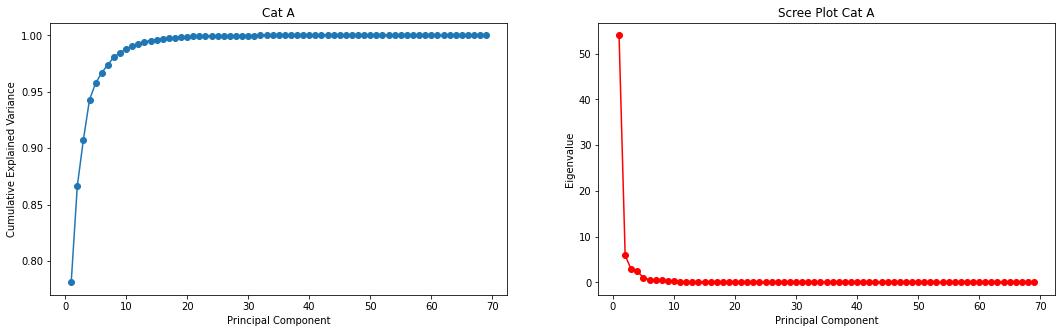

In [ ]:
# Exclude QP A
perform_pca(data, 'A')

In [ ]:
# Include QP A
perform_pca(data, 'A', False)

BS test passed for category A with p_value = 0.0
KMO test fail for category A with value = nan
